# World Cup Prediction

The goal of this notebook is to provide a evaluate if **Support Vector Machine** could be a good algorithm to predict which country will win in the next World Cup.

More information about the collected data is [here](https://github.com/bara-bash/worldcupproject).

The order of this notebook is as follows:

1. Data preparation
2. Classification
3. Conclusions

In [1]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.svm import SVC
from typing import Tuple
import numpy as np

from sklearn import preprocessing
from sklearn.metrics import accuracy_score, average_precision_score
from sklearn.metrics import precision_recall_curve
import warnings

sns.set_style('whitegrid')
warnings.filterwarnings('ignore')

## Data preparation

Our data has 11 columns:
* Fifa World Cup - year of the World Cup	
* Group - name of the group
* Teams - name of the team (Country)
* Match played - how many matches did the team play
* Match won - how many matches it won	
* Draw - number of draws
* Lost - number of loses
* Goals for - total number of goals
* Goals against - total number of lot goals
* Goals difference - difference between goals for and against
* Points - total points

We are going to rename them, so reffering to them will be easier in later parts of this notebook.

* Fifa World Cup - `year`
* Group - `group`
* Teams - `country`
* Match played - `played`
* Match won - `match_won`
* Draw - `match_draw`
* Lost - `match_lost`
* Goals for - `goals_won`
* Goals against - `goals_lost`
* Goals difference - `goals_diff`
* Points - `points`

In [2]:
df = pd.read_excel('WorldCupData.xlsx')
df.rename(columns={'Fifa World Cup': 'year', 'Group': 'group', 'Teams': 'country',
                  'Match played': 'played', 'Match won': 'match_won', 'Draw': 'match_draw', 'Lost': 'match_lost',
                  'Goals for': 'goals_won', 'Goals against': 'goals_lost', 
                   'Goals difference': 'goals_diff', 'Points': 'points'}, inplace=True)
df.head()

,year,group,country,played,match_won,match_draw,match_lost,goals_won,goals_lost,goals_diff,points
0,2014,Group A,Brazil,3,2,1,0,7,2,5,7
1,2014,Group A,Mexico,3,2,1,0,4,1,3,7
2,2014,Group A,Croatia,3,1,0,2,6,6,0,3
3,2014,Group A,Cameroon,3,0,0,3,1,9,-8,0
4,2014,Group B,Netherlands,3,3,0,0,10,3,7,9


### Encoding labels

We need to encode **countries** and **groups** to *numerical* values, because SVM operates on numerical values only.
We introduce separate columns for these - `encoded_country` and `encoded_group`.

In [3]:
encoder_countries = preprocessing.LabelEncoder()
encoder_countries.fit(list(df['country'].unique()))
encoder_group = preprocessing.LabelEncoder()
encoder_group.fit(list(df['group'].unique()))
df['encoded_country'] = encoder_countries.transform(df['country'])
df['encoded_group'] = encoder_group.transform(df['group'])
df.head()

,year,group,country,played,match_won,match_draw,match_lost,goals_won,goals_lost,goals_diff,points,encoded_country,encoded_group
0,2014,Group A,Brazil,3,2,1,0,7,2,5,7,8,0
1,2014,Group A,Mexico,3,2,1,0,4,1,3,7,32,0
2,2014,Group A,Croatia,3,1,0,2,6,6,0,3,15,0
3,2014,Group A,Cameroon,3,0,0,3,1,9,-8,0,10,0
4,2014,Group B,Netherlands,3,3,0,0,10,3,7,9,34,1


### Preparing features

Our goal is to **classify** which team will win, so we need to introduce a new column in which we will store information if the team won the World Cup at that year.

In `if_won` column we will store `1` if the country won the World Cup from that year, otherwise `0`.

In [4]:
if_won = []
years = df['year'].unique()

df['if_won'] = np.zeros(len(df))
for y in years:
    df_y = df[df['year'] == y]
    max_points = df_y['points'].max()
    for idx, row in df_y.iterrows():
        if row['points'] == max_points:
            df['if_won'].iloc[idx] = 1

df[df['if_won'] == 1].head()

,year,group,country,played,match_won,match_draw,match_lost,goals_won,goals_lost,goals_diff,points,encoded_country,encoded_group,if_won
4,2014,Group B,Netherlands,3,3,0,0,10,3,7,9,34,1,1.0
8,2014,Group C,Colombia,3,3,0,0,9,2,7,9,13,2,1.0
20,2014,Group F,Argentina,3,3,0,0,6,3,3,9,2,5,1.0
28,2014,Group H,Belgium,3,3,0,0,4,1,3,9,5,7,1.0
36,2010,Group B,Argentina,3,3,0,0,7,1,6,9,2,1,1.0


#### Next world cup feature

What we actually need is to know if the country team will win not the *current* World Cup, but the **next one** (because when having results from this year we can easily say who is the winner by just looking at points).

In `if_win_net` column we will store `1` if the country will win the next World Cup, otherwise `0`.

In [5]:
df['if_win_next'] = np.zeros(len(df)) - 1
years = df['year'].sort_values().unique()
for i in range(len(years) - 1):
    df_this_year = df[df['year'] == years[i]]
    df_next_year_winners = df[df['if_won'] == 1][df['year'] == years[i+1]]['encoded_country'].values
    for idx, row in df_this_year.iterrows():
        if row['encoded_country'] in df_next_year_winners:
            df['if_win_next'].iloc[idx] = 1
        else:
            df['if_win_next'].iloc[idx] = 0
df[df['if_win_next'] == 1].head()

,year,group,country,played,match_won,match_draw,match_lost,goals_won,goals_lost,goals_diff,points,encoded_country,encoded_group,if_won,if_win_next
36,2010,Group B,Argentina,3,3,0,0,7,1,6,9,2,1,1.0,1.0
48,2010,Group E,Netherlands,3,3,0,0,5,1,4,9,34,4,1.0,1.0
72,2006,Group C,Argentina,3,2,1,0,8,1,7,7,2,2,0.0,1.0
73,2006,Group C,Netherlands,3,2,1,0,3,1,2,7,34,2,0.0,1.0
100,2002,Group B,Spain,3,3,0,0,9,4,5,9,52,1,1.0,1.0


## Classification

For **classification** we will use SVM algorithm with **linear kernel**. We will try to predict `if_win_next` using features listed in `features`. As a evaluation metric we will use **precision**. Precision is the ability of the classifier not to label **negative sample** as **positive one** (so we want our classifier to be good at predicting winners not loosers).

We divide our data set into 2 datasets:
* training set (data before 2010)
* testing set (data in 2010)

We don't use data from 2014, because we don't know future results.

In [6]:
features = ['year', 'encoded_group', 'encoded_country', 'played', 'match_won', 'match_draw', 
            'match_lost', 'goals_won', 'goals_lost', 'goals_diff', 'points', 'if_won']
output = ['if_win_next']

df_test = df[df['year'] == 2010]
df_train = df[df['year'] < 2010]

def plot_precision_vs_recall(y_true, y_pred):
    average_precision = average_precision_score(y_true, y_pred)
    precision, recall, thresholds = precision_recall_curve(y_true, y_pred)

    plt.step(recall, precision, color='b', alpha=0.2,
             where='post')
    plt.fill_between(recall, precision, step='post', alpha=0.2,
                     color='b')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.title('Average precision-recall score: {0:0.2f}'.format(
      average_precision))

### Training

For training set we achieve 0.74 average precision score. This means that we sometimes label negative samples as positive.

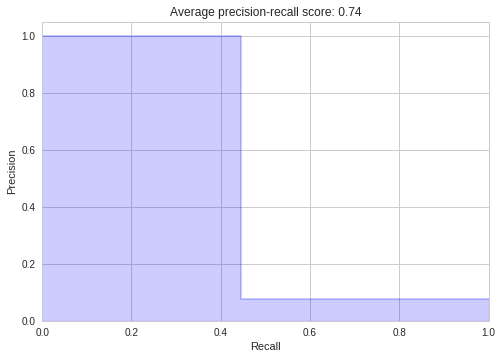

In [7]:
svm = SVC(kernel='linear')
svm.fit(df_train[features], df_train[output])
pred_train = svm.predict(df_train[features])

plot_precision_vs_recall(df_train[output], pred_train)

### Testing

For testing set we achieve much lower precision score - 0.03. It means that our algoritm is overfitting the training score and will not generalize well, we fail to do good predictions.

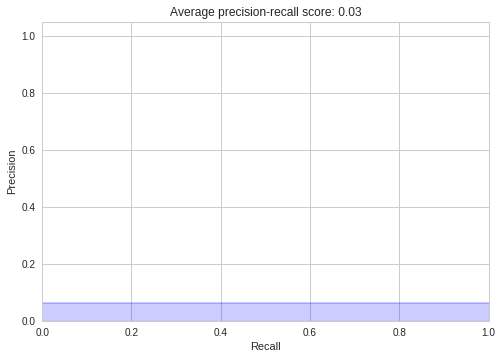

In [8]:
pred_test = svm.predict(df_test[features])
plot_precision_vs_recall(df_test[output], pred_test)

### Prediction for this year

Anyway let's use that to predict the winner!

In [9]:
df_unknown = df[df['year'] == 2014]
df_unknown.index = list(range(0, len(df_unknown)))
df_unknown.reindex()
p_unknown = svm.predict(df_test[features])
for i in range(len(df_unknown)):
    if p_unknown[i] == 1:
        print(df_unknown['country'].iloc[i], 'will win!')

USA will win!


In [10]:
df[df['country'] == 'USA']

,year,group,country,played,match_won,match_draw,match_lost,goals_won,goals_lost,goals_diff,points,encoded_country,encoded_group,if_won,if_win_next
25,2014,Group G,USA,3,1,1,1,4,4,0,4,59,6,0.0,-1.0
40,2010,Group C,USA,3,1,2,0,4,3,1,5,59,2,0.0,0.0
83,2006,Group E,USA,3,0,1,2,2,6,-4,1,59,4,0.0,0.0
109,2002,Group D,USA,3,1,1,1,5,6,-1,4,59,3,0.0,0.0
151,1998,Group F,USA,3,0,0,3,1,5,-4,0,59,5,0.0,0.0
162,1994,Group A,USA,3,1,1,1,3,3,0,4,59,0,0.0,0.0


## Conclusions

This approach doesn't seem to generalize well - the precision for testing set is very low. Anyway we predicted that USA will win this year.

### Next steps:

1. Feature engineering: 
    * remove unnecessary features
    * gather more data (data about players?)
    * check if they correlate with each other (probably we can drop some columns f.e. `goals_diff`)
2. SVM parameter tunning - we tried only **linear** kernel and we didn't even tune the *C* parameter. We could also try to use **rbf** kernel and play with its *C* and *gamma* parameter
3. Use different algorithms for prediction - for example: linear regression, logistic regression, or more sophisticated ones like Ridge.